# Load Data

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
if 'google.colab' in str(get_ipython()):
    drive.mount("/content/drive")
    %cd /content/drive/MyDrive/dataset/DSA4212/assignment_2/

Mounted at /content/drive
/content/drive/MyDrive/dataset/DSA4212/assignment_2


In [3]:
import matplotlib.pyplot as plt
import numpy as onp
import pandas as pd
import re
from scipy.stats import norm
from sklearn.metrics import mean_squared_error

In [4]:
anime = pd.read_csv("assignment_2_anime.csv")
train = pd.read_csv("assignment_2_ratings_train.csv")
test = pd.read_csv("assignment_2_ratings_test.csv")

In [5]:
anime.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [6]:
len(anime)

12294

In [7]:
len(anime.anime_id.unique())

12294

In [8]:
train.head()

,user_id,anime_id,rating
0,20170,10794,6
1,24592,21995,5
2,18358,7054,10
3,59267,488,7
4,69313,30544,4


In [9]:
len(train)

4436068

In [10]:
test.head()

,user_id,anime_id,rating
0,44017,13161,4
1,14307,14993,7
2,55155,268,9
3,63515,2889,9
4,54059,2581,7


In [11]:
len(test)

1901173

# Naive Model

## Random Model

### Random Integer

In [12]:
predicted_test_4 = test.copy()
predicted_test_4["predicted_rating"] = onp.random.randint(low = 1, high = 10, size = len(test))

In [13]:
mean_squared_error(predicted_test_4["rating"], predicted_test_4["predicted_rating"])

17.02648943573257

### Normal

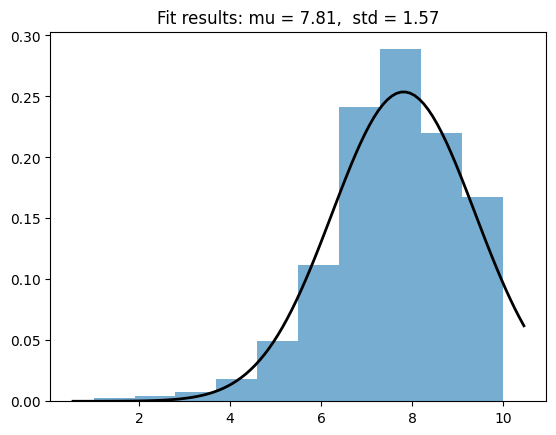

In [14]:
miu, sd = norm.fit(train["rating"])

# Plot the histogram.
plt.hist(train["rating"], density=True, alpha=0.6)

# Plot the PDF.
xmin, xmax = plt.xlim()
x = onp.linspace(xmin, xmax, 100)
p = norm.pdf(x, miu, sd)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (miu, sd)
plt.title(title)

plt.show()

In [15]:
predicted_test_5 = test.copy()
predicted_test_5["predicted_rating"] = onp.random.normal(loc = miu, scale = sd, size = len(test))

In [16]:
mean_squared_error(predicted_test_5["rating"], predicted_test_5["predicted_rating"])

4.953609173542322

## Movie Mean Model

In [17]:
predicted_test_1 = test.merge(anime, how = "left", on = "anime_id", suffixes = ('','_predicted'))
predicted_test_1.drop(['name', 'genre', 'type', 'episodes', 'members'], axis = 1, inplace = True)

In [18]:
predicted_test_1

,user_id,anime_id,rating,rating_predicted
0,44017,13161,4,7.25
1,14307,14993,7,6.66
2,55155,268,9,8.05
3,63515,2889,9,7.60
4,54059,2581,7,8.24
...,...,...,...,...
1901168,56619,31483,10,7.77
1901169,24755,1210,8,8.40
1901170,17346,15225,6,7.46
1901171,28874,5041,8,7.29


In [19]:
onp.mean(anime["rating"])

6.473901690981432

In [20]:
predicted_test_1["rating_predicted"] = predicted_test_1["rating_predicted"].fillna(6.474)

In [21]:
mean_squared_error(predicted_test_1["rating"], predicted_test_1["rating_predicted"])

2.076648931713213

## Movie Mean Model in Train

In [22]:
avg_anime_train_rating = train.groupby("anime_id", as_index = False).agg({"rating": [onp.mean]})

In [23]:
predicted_test_2 = test.merge(avg_anime_train_rating, how = "left", on = "anime_id", suffixes = ('','_predicted'))

<ipython-input-23-6271d5ed7346>:1: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  predicted_test_2 = test.merge(avg_anime_train_rating, how = "left", on = "anime_id", suffixes = ('','_predicted'))
<ipython-input-23-6271d5ed7346>:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  predicted_test_2 = test.merge(avg_anime_train_rating, how = "left", on = "anime_id", suffixes = ('','_predicted'))


In [24]:
avg_anime_train_rating["rating"].mean()

mean    6.677847
dtype: float64

In [25]:
predicted_test_2

,user_id,anime_id,rating,"(rating, mean)"
0,44017,13161,4,7.375411
1,14307,14993,7,7.111111
2,55155,268,9,8.172632
3,63515,2889,9,7.718577
4,54059,2581,7,8.378289
...,...,...,...,...
1901168,56619,31483,10,7.792308
1901169,24755,1210,8,8.470229
1901170,17346,15225,6,7.612141
1901171,28874,5041,8,7.506818


In [26]:
predicted_test_2[('rating', 'mean')] = predicted_test_2[('rating', 'mean')].fillna(6.678)

In [27]:
mean_squared_error(predicted_test_2["rating"], predicted_test_2[('rating', 'mean')])

2.061849265389794

## User Mean Model in Train

In [28]:
avg_user_train_rating = train.groupby("user_id", as_index = False).agg({"rating": [onp.mean]})

In [29]:
predicted_test_3 = test.merge(avg_user_train_rating, how = "left", on = "user_id", suffixes = ('','_predicted'))

<ipython-input-29-c267bf7fd40a>:1: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  predicted_test_3 = test.merge(avg_user_train_rating, how = "left", on = "user_id", suffixes = ('','_predicted'))
<ipython-input-29-c267bf7fd40a>:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  predicted_test_3 = test.merge(avg_user_train_rating, how = "left", on = "user_id", suffixes = ('','_predicted'))


In [30]:
predicted_test_3

,user_id,anime_id,rating,"(rating, mean)"
0,44017,13161,4,7.691011
1,14307,14993,7,7.419919
2,55155,268,9,9.015152
3,63515,2889,9,8.614458
4,54059,2581,7,7.976190
...,...,...,...,...
1901168,56619,31483,10,7.960073
1901169,24755,1210,8,7.634146
1901170,17346,15225,6,6.373737
1901171,28874,5041,8,8.111111


In [31]:
avg_user_train_rating[('rating', 'mean')].mean()

8.216179937862996

In [32]:
predicted_test_3[('rating', 'mean')] = predicted_test_3[('rating', 'mean')].fillna(8.216)

In [33]:
mean_squared_error(predicted_test_3["rating"], predicted_test_3[('rating', 'mean')])

1.8633073135300804